# Titanic
## Predict survival on the Titanic using Gradient Boost


# Load data into Pandas DataFrame

In [18]:
import pandas as pd

# Read into DataFrames
train = pd.read_csv("titanic/train.csv")
test = pd.read_csv("titanic/test.csv")

# At first lets check the train DataFrame
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# Check for `null` values

In [19]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Null values found in `Age: 177`, `Cabin: 687`, `Embarked: 2`

# Check data types

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Check distribution of `Age` before imputing null values

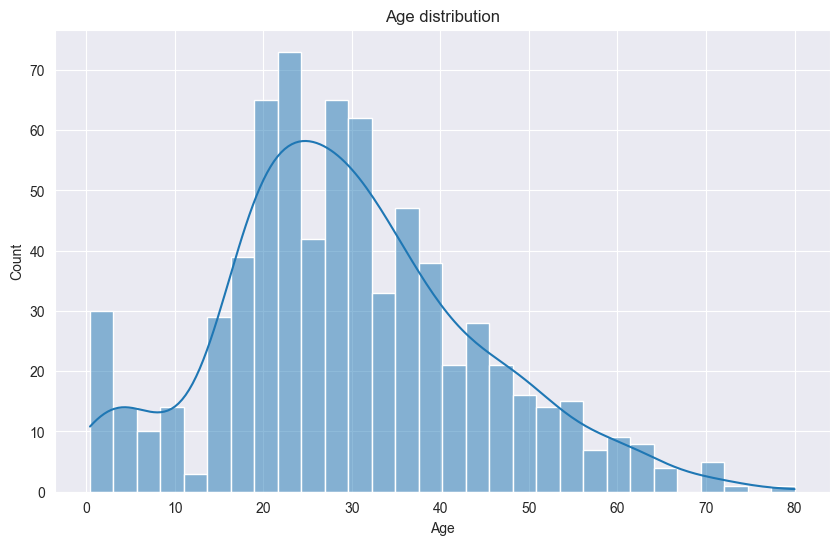

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a histogram with Age variable
plt.figure(figsize=(10, 6))
sns.histplot(train["Age"], bins=30, kde=True)
plt.title("Age distribution")
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Impute null values for `Age` variable where distribution is right-skewed

### When we get right-skewed distribution of a numerical variable the better practice is use `median` value for imputing missing values. We can't use `mean` value because it will not represent the central tendency of the distribution, because the mean value will come from the right area of distribution.
### But for the this time I will use MICE to impute those values because this technique especially good for non-normally distributed  or skewed data.

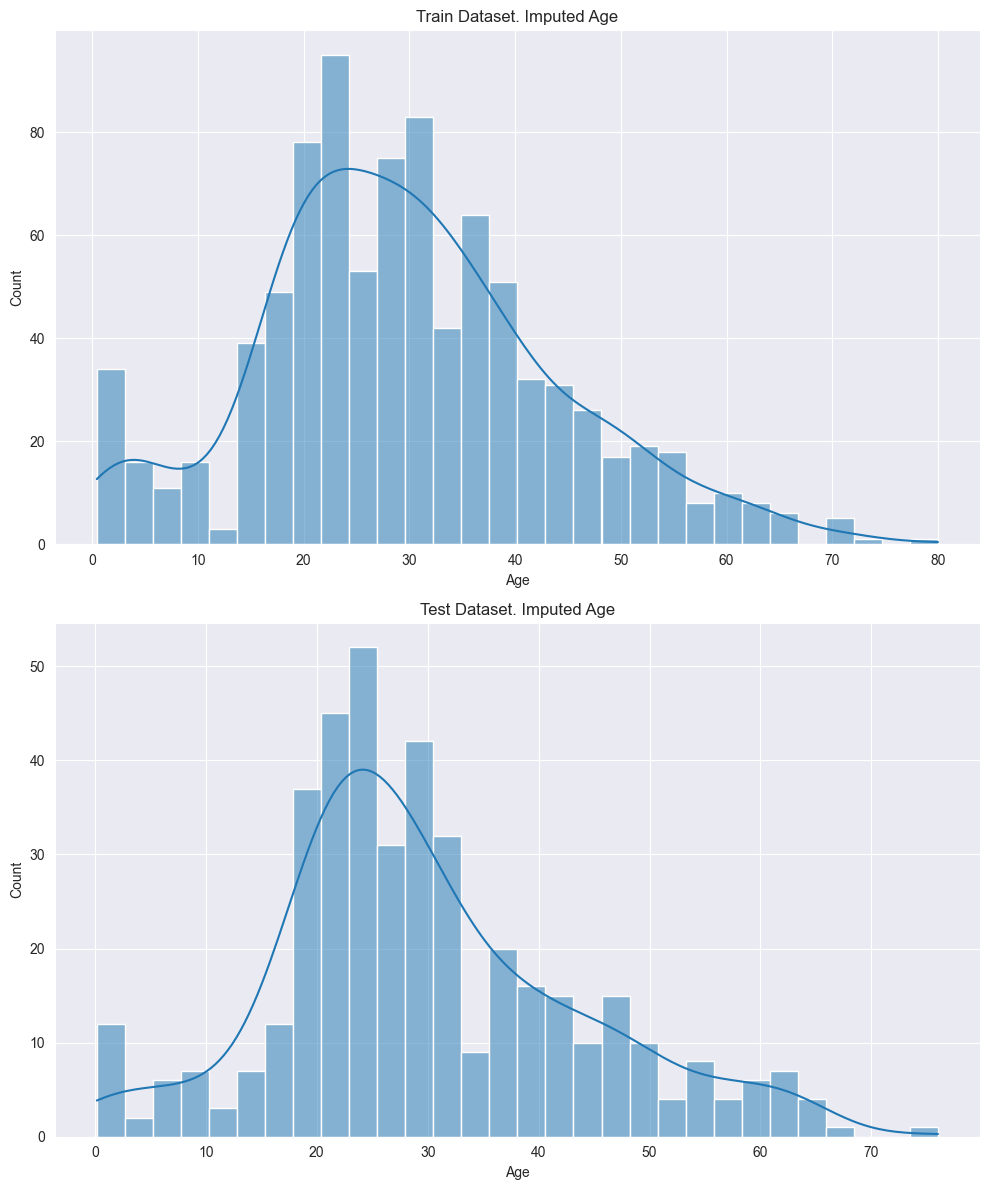

In [22]:
import miceforest as mf

# Prepare Sex columns
mapping = {'male': 1, 'female': 0}
train["Sex"] = train["Sex"].map(mapping)
test["Sex"] = test["Sex"].map(mapping)

# Create kernel for train dataset 
kernel = mf.ImputationKernel(data=train[["Age", "Survived", "Fare", "Sex"]], datasets=1, save_all_iterations=True)

# Launch the MICE imputation for train dataset
kernel.mice(10)

# Kernel for test dataset
kernel_test = mf.ImputationKernel(data=test[["Age", "Fare", "Sex"]], datasets=1, save_all_iterations=True)

# Launch the kernel_test
kernel_test.mice(10)

# Get imputed data for test and train datasets
imputed_data_train = kernel.complete_data(0)
imputed_data_test = kernel_test.complete_data(0)

# Replace old columns with new columns
train[["Age", "Survived", "Fare", "Sex"]] = imputed_data_train
test[["Age", "Fare", "Sex"]] = imputed_data_test

# Create subplots 
_ , axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Plot for train dataset
sns.histplot(train['Age'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Train Dataset. Imputed Age")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Count")

# Plot for test dataset
sns.histplot(test['Age'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Test Dataset. Imputed Age")
axes[1].set_xlabel("Age")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [23]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Cabin 
### Which passengers had assigned cabins and which did not?  

/var/folders/2f/8bjntx8d5m7f9brr2h6z4vvr0000gn/T/ipykernel_66844/2901812138.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Cabin'].fillna('Missing', inplace=True)


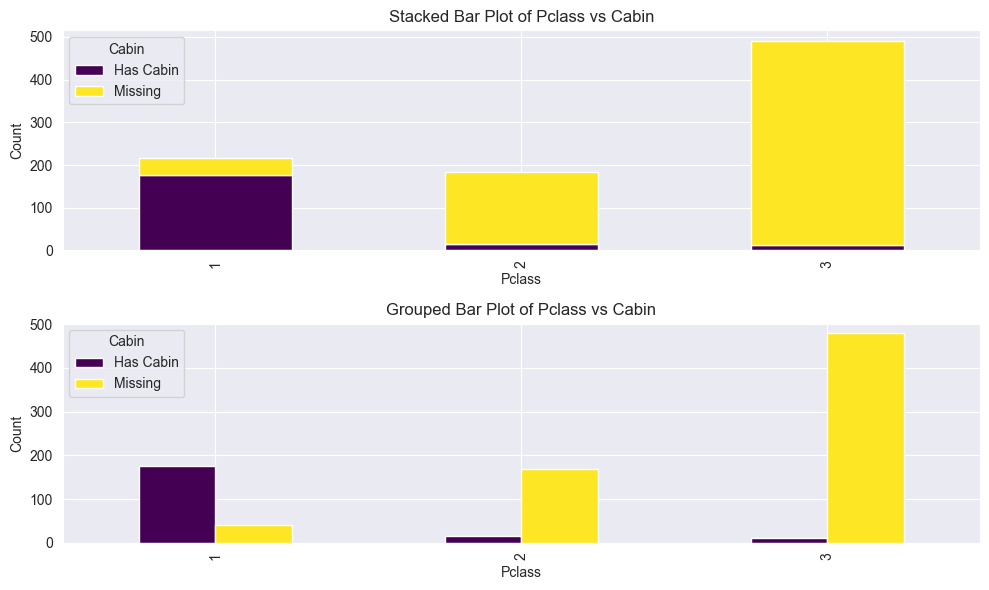

In [24]:
train['Cabin'].fillna('Missing', inplace=True)
cabin = train['Cabin'].apply(lambda  x: 'Has Cabin' if x != 'Missing' else 'Missing')
contingency_table = pd.crosstab(train['Pclass'], cabin)
_ , axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Stacked Bar Plot
contingency_table.plot(kind='bar', stacked=True, colormap='viridis', ax=axes[0])
axes[0].set_title('Stacked Bar Plot of Pclass vs Cabin')
axes[0].set_xlabel('Pclass')
axes[0].set_ylabel('Count')

# Grouped Bar Plot
contingency_table.plot(kind='bar', colormap='viridis', ax=axes[1])
axes[1].set_title('Grouped Bar Plot of Pclass vs Cabin')
axes[1].set_xlabel('Pclass')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


# There is a lot of missing values in Third and Second class tickets so it's better to just drop the `Cabin` column.


In [25]:
train.drop(columns=['Cabin'], inplace=True)
test.drop(columns=['Cabin'], inplace=True)

# Impute `Embarked` variable with mod value

In [26]:
# Impute with mod value
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace=True)

/var/folders/2f/8bjntx8d5m7f9brr2h6z4vvr0000gn/T/ipykernel_66844/1226287962.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
/var/folders/2f/8bjntx8d5m7f9brr2h6z4vvr0000gn/T/ipykernel_66844/1226287962.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

# Drop `PassengerId`

In [27]:
train.drop(columns=['PassengerId'], inplace=True)
test.drop(columns=['PassengerId'], inplace=True)

# Tokenize `Name` and `Ticket`


In [28]:
def tokenize(df : pd.DataFrame):
    """Tokenizing the columns"""
    df = df.copy()
    
    def name(x : str):
        """Splitting the string using space character then removing non-alphabetic characters"""
        return "".join([v.strip(",()[].\"'") for v in x.split(" ")])
    
    def ticket_number(x : str):
        """Splitting the string by space and then taking the last element"""
        return x.split(" ")[-1]
    
    def ticket_item(x : str):
        """Splitting string then if length 2D array is 1 it means there's no item otherwise we take return all items"""
        item = x.split(" ")
        if len(item) == 1:
            return "NONE"
        return " ".join(item[0:-1])
    
    df["Name"] = df["Name"].apply(name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)
    return df

preprocessed_train = tokenize(train)
preprocessed_test = tokenize(test)

# Create input features list

In [29]:
input_features = list(preprocessed_train.columns)
input_features.remove("Ticket")
input_features.remove("Survived")
input_features

['Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked',
 'Ticket_number',
 'Ticket_item']

# Convert Pandas DataFrame to TensorFlow Dataset


In [30]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

def tokenize_name(features, labels = None):
    features["Name"] = tf.strings.split(features["Name"])
    return features, labels

# Convert Pandas DataFrame into tensorflow dataset

In [31]:
tf_train = tfdf.keras.pd_dataframe_to_tf_dataset(preprocessed_train, label="Survived").map(tokenize_name)
tf_test = tfdf.keras.pd_dataframe_to_tf_dataset(preprocessed_test).map(tokenize_name)

# Train Gradient Boost model with default parameters

In [32]:
model = tfdf.keras.GradientBoostedTreesModel(
    verbose=0,
    features=[tfdf.keras.FeatureUsage(n) for n in input_features],
    exclude_non_specified_features=True,
    random_seed=9
)
model.fit(tf_train)

self_eval = model.make_inspector().evaluation()
print(f"Accuracy={self_eval.accuracy}, Loss={self_eval.loss}")

[WARNING 24-07-17 13:54:59.8129 PDT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-07-17 13:54:59.8129 PDT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-07-17 13:54:59.8129 PDT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Accuracy=0.8736842274665833, Loss=0.7563692927360535


[INFO 24-07-17 13:55:00.0156 PDT kernel.cc:1233] Loading model from path /var/folders/2f/8bjntx8d5m7f9brr2h6z4vvr0000gn/T/tmp_fr6nh65/model/ with prefix 54f48dec07724a83
[INFO 24-07-17 13:55:00.0169 PDT abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-07-17 13:55:00.0169 PDT kernel.cc:1061] Use fast generic engine


In [33]:
model.summary()

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (10):
	Age
	Embarked
	Fare
	Name
	Parch
	Pclass
	Sex
	SibSp
	Ticket_item
	Ticket_number

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.           "Sex"  1.000000 ################
    2.          "Fare"  0.264867 #
    3.        "Pclass"  0.257798 #
    4.           "Age"  0.256882 #
    5.   "Ticket_item"  0.212199 
    6. "Ticket_number"  0.196407 
    7.      "Embarked"  0.189933 
    8.         "SibSp"  0.187050 
    9.         "Parch"  0.179341 

Variable Importance: NUM_AS_ROOT:
    1. "Sex" 23.000000 

Variable Importance: NUM_NODES:
    1.          "Fare"

# Training a model with hyperparameter tunning 

In [34]:
# Create a tuner that will iterate 1000 time to find best hyperparameters
tuner = tfdf.tuner.RandomSearch(num_trials=1000)
